# Model training and selection

In [1]:
import pickle
from tqdm.notebook import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

import torch
import torchvision.transforms as transforms
import torchvision.models
import torch.optim as optim
import torch.nn as nn

import time

In [2]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [3]:
patch_size = 300

SIZE_X = patch_size
SIZE_Y = patch_size

MODE = "a"
MODEL_NAME = "ejemplo"

In [4]:
def init_weights(m): # XAVIER initialization for final layer weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init():
  global net, loss_function, scheduler, optimizer, MODEL_NAME
  
  net = torchvision.models.resnet18(pretrained=True).to(device)
      
  for param in net.parameters():
      param.requires_grad = False # Freezing the convolutional layers
      
  net.fc = nn.Sequential(
                nn.Linear(512, 128), #512
                nn.ReLU(inplace=True),
                nn.Linear(128, 2),
                nn.Softmax(dim = -1)
                ).to(device)

  net.fc.apply(init_weights) # Xavier init

  print(f"loading {MODEL_NAME}")

  # net.fc = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

  print("Number of free parameters: ", sum(p.numel() for p in net.fc.parameters()))

  #Hyperparameters:
  learning_rate = 0.0001 # LR
  loss_function = nn.BCELoss()
  # Loss # [1,0] es positivo y [0,1] negativo # weight = torch.tensor([(495+201)/(2*495), (201+495)/(2*201)]).to(device)) # El negativo cuesta 2.5... mas
  optimizer = optim.Adam(net.fc.parameters(), lr=learning_rate)# Optimizer
  lambda1 = lambda epoch: 0.8 ** epoch # Scheduler
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

init()

loading ejemplo
Number of free parameters:  65922


In [5]:
def fwd_pass(X, y, train=False):
# IMPORTANTE, TRAIN = FALSE PARA QUE NO ENTRENE CON EL TEST DATA ESTO ES PARA PODER HACER TEST MIENTRAS ENTRENO Y VALIDO, 
# SE ESPERA QUE LA EXACTITUD EN EL TEST DE VALIDACIÓN SEA MENOR
    if train: 
        net.zero_grad()

    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
    conf_m = confusion_matrix( [torch.argmax(i) for i in y.cpu()],[torch.argmax(i) for i in outputs.cpu()], labels=(0, 1))
    f1 = conf_m[0][0]/(conf_m[0][0]+0.5*(conf_m[1][0]+conf_m[0][1]))
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    del outputs

    return acc, loss, f1

In [6]:
def validate(val_X, val_y, size=32):
# Hago un test con datos en una región aleatoria para que la distribución sea mejor
  val_X, val_y = shuffle(val_X, val_y) 
  
  if size > 0.7*len(val_y):
    ramdom_start = 0
  else:
    ramdom_start = np.random.randint(len(val_X)-size)

  X, y = val_X[ramdom_start:ramdom_start+size].to(device), val_y[ramdom_start:ramdom_start+size].to(device)
  val_acc, val_loss, val_f1 = fwd_pass(X.view(-1, 3, SIZE_X, SIZE_Y), y, train=False)
  del X, y

  return val_acc, val_loss, val_f1 # accuracy y loss en validation set

In [7]:
def test():
  X, y = test_X.to(device), test_y.to(device)
  test_acc, test_loss = fwd_pass(X.view(-1, 3, SIZE_X, SIZE_Y), y)
  del X, y

  return test_acc, test_loss

In [8]:
def shuffle(X, y): # Esta función debería hacer un shuffle del data set sin desordenar las etiquetas
  c = list(zip(X, y))
  random.shuffle(c)
  X, y = zip(*c)
  return torch.stack(X), torch.stack(y)

In [9]:
%%time

def train():

  global net, loss_function, scheduler, optimizer, train_X, train_y, MODEL_NAME

  print(MODEL_NAME)
  BATCH_SIZE = 16
  EPOCHS = 10

  N_BATCHES = len(range(0, len(train_X), BATCH_SIZE))
  
  with open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{MODEL_NAME}.log", MODE) as f:
    for epoch in range(EPOCHS):
      acc, loss, f1 = 0, 0, 0
      val_acc, val_loss, val_f1 = 0, 0, 0

      train_X, train_y = shuffle(train_X, train_y)

      print("\nEPOCH: ", epoch+1)

      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,3,SIZE_X,SIZE_Y).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)
        
        net.train() # Making sure that the model is in training mode
        
        acc_aux, loss_aux, f1_aux = fwd_pass(batch_X, batch_y, train=True)
        
        acc += acc_aux/N_BATCHES # Calculating the average loss and acc trough batches
        loss += loss_aux/N_BATCHES
        f1 += f1_aux/N_BATCHES

        del batch_X, batch_y
      '''
      for i in tqdm(range(0, int(len(val_X)*0.2), BATCH_SIZE)):
        net.eval() # Making sure that the model is not training and deactivate droptout
        
        val_acc_aux, val_loss_aux = validate(val_X, val_y, size=BATCH_SIZE)
      
        val_acc += val_acc_aux/N_BATCHES_VAL # Calculating the average loss and acc trough batches
        val_loss += val_loss_aux/N_BATCHES_VAL
      '''

      val_acc, val_loss, val_f1 = validate(val_X, val_y, size=300)

      print("Val loss: ", val_loss.item()," Train loss: ", loss.item(), "\n")
      print("Val acc: ", val_acc," Train acc: ", acc, "\n")
      print("Val f1: ", val_f1," Train f1: ", f1, "\n")

      f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),3)},{round(float(loss),4)},{round(float(val_acc),3)},{round(float(val_loss),4)}\n")
      f.write("\n\n")

      print("Learning Rate: ", optimizer.param_groups[0]["lr"])
      scheduler.step() # Changing the learning rate

    torch.save(net, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")


CPU times: total: 0 ns
Wall time: 0 ns


In [10]:
# Choosing only the images from the according splits (10CV)

for SPLIT in range(10):
    MODEL_NAME = f"ejemplo_{SPLIT}"
    data_set_name = "data_set_x20_25%_split"

    X, y = torch.tensor([]), torch.tensor([])

    TRAIN_SPLITS =list(range(10))
    TRAIN_SPLITS.remove(SPLIT)

    for i in TRAIN_SPLITS:
        split_name = data_set_name + f"{i}"
        with open(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/datasets/{split_name}.obj", 'rb') as f:
            data_set = pickle.load(f)
        
        X = torch.cat((X, data_set.inputs.float()))
        y = torch.cat((y, data_set.labels.float()))

    train_X, train_y = shuffle(list(X), list(y))

    print(len(train_y))

    split_name = data_set_name + f"{SPLIT}"

    with open(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/datasets/{split_name}.obj", 'rb') as f:
        data_set = pickle.load(f)

    val_X, val_y = shuffle(data_set.inputs.float(), data_set.labels.float())

    init()

    train()


17114
loading ejemplo_0
Number of free parameters:  65922
ejemplo_0


In [21]:
def learning_curve(NAME):
  fig, axs = plt.subplots(2, figsize = (7,6))

  acc_df = pd.read_csv(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{NAME}.log")
  acc_df.columns = ["MODEL_NAME", "TIME", "ACC", "LOSS", "VAL_ACC", "VAL_LOSS"]

  fig, axs = plt.subplots(2, figsize=(5,7))
  #ax = plt.gca() # GET CURRENT AXIS

  axs[0].legend("MODEL_NAME", loc=2)

  acc_df.plot(y="ACC", ax=axs[0])
  acc_df.plot(y="VAL_ACC", ax=axs[0])

  acc_df.plot(y="LOSS", ax=axs[1])
  acc_df.plot(y="VAL_LOSS",ax=axs[1])

  fig.show()
  fig.savefig(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\lc\\l_curve_{NAME}.pdf")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_12252\1170274862.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_12252\1170274862.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_12252\1170274862.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_12252\1170274862.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_12252\1170274862.py:18: UserWarning: Matplotlib 

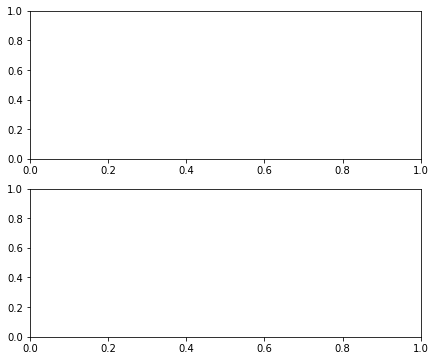

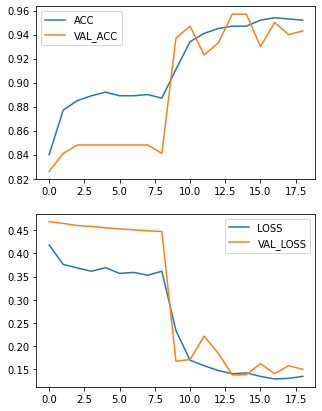

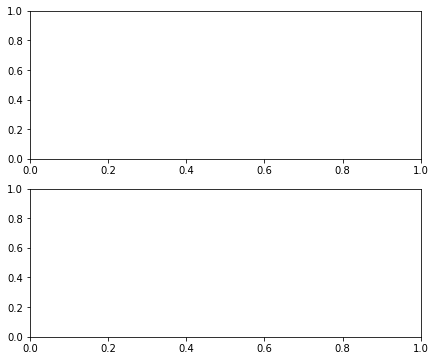

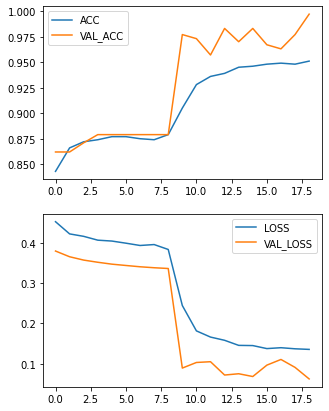

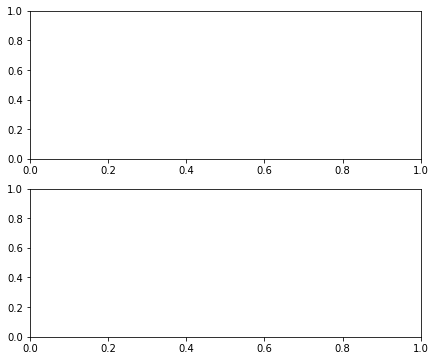

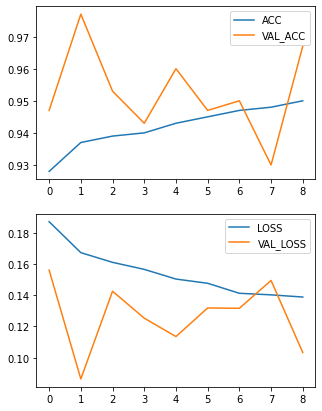

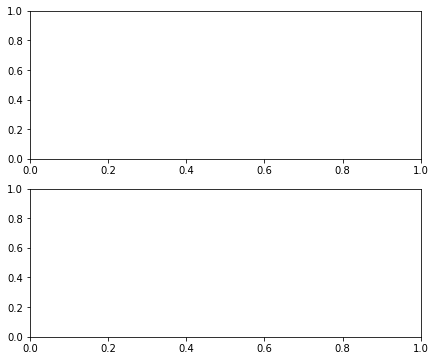

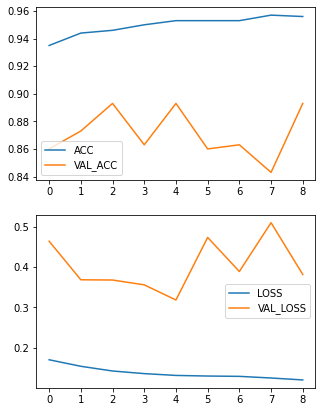

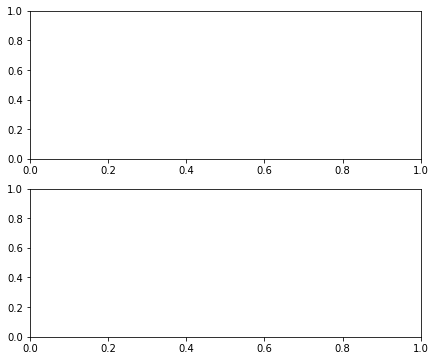

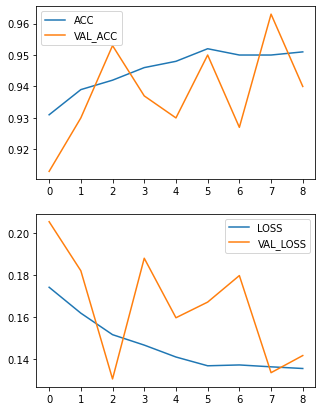

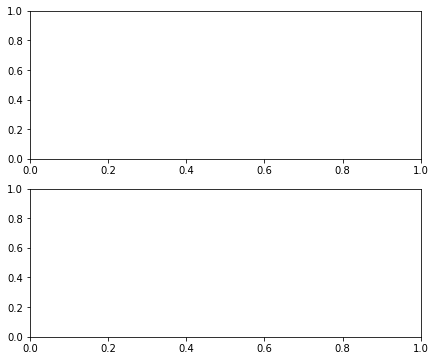

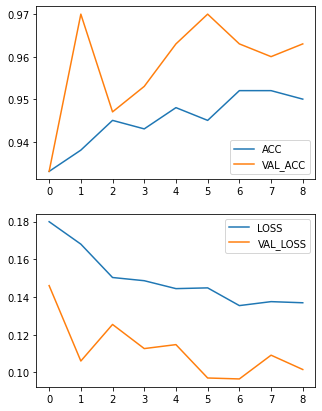

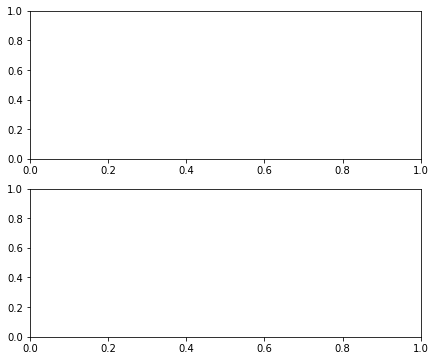

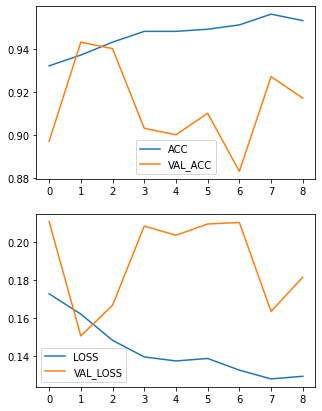

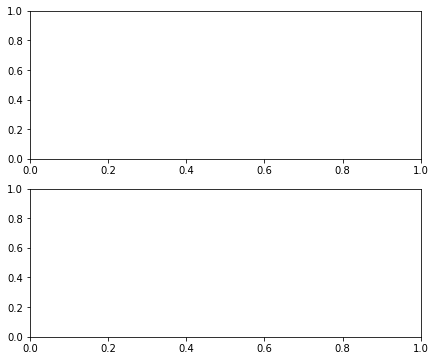

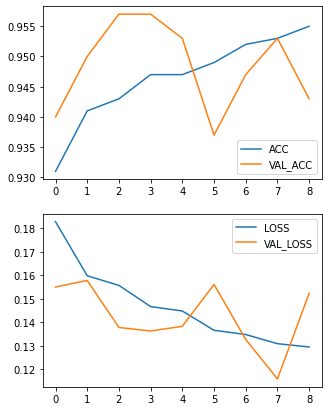

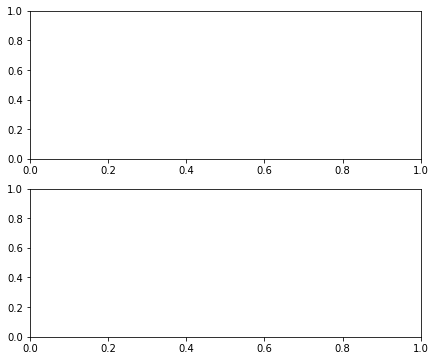

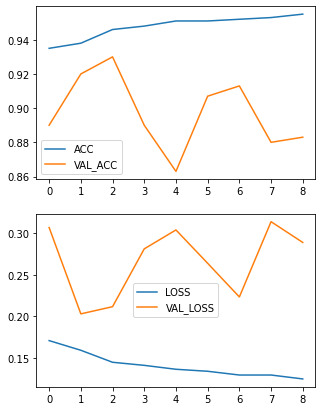

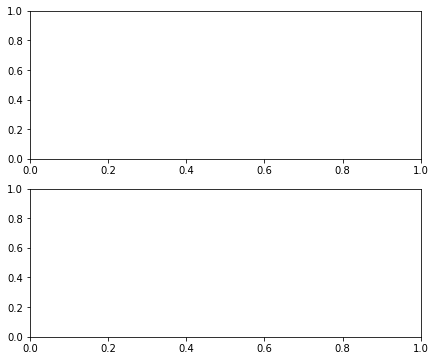

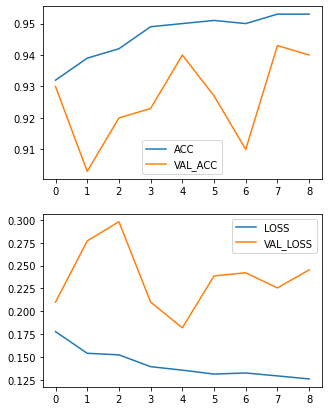

In [27]:
for SPLIT in range(10):
    NAME = MODEL_NAME[:-1]+f"{SPLIT}"
    learning_curve(NAME)